## Setup and Installation

In [1]:
%pip install wfdb  # For reading MIT-BIH format

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wfdb
from scipy import signal
import urllib.request
import zipfile

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_3', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('data', exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


2025-05-13 22:00:26.185343: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 22:00:26.190467: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 22:00:26.206571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747173626.233327   49779 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747173626.241560   49779 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747173626.274256   49779 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Download MIT-BIH dataset
data_dir = 'data/mitdb'
if not os.path.exists(data_dir):
    print("Downloading MIT-BIH Arrhythmia Database...")
    url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    zip_path = 'data/mitdb.zip'
    
    # Download dataset
    urllib.request.urlretrieve(url, zip_path)
    
    # Extract dataset
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    # Clean up
    os.remove(zip_path)
    print("Dataset downloaded and extracted successfully.")

Dataset downloaded and extracted successfully.


## 1. Data Loading and Preprocessing

Signal shape: (650000, 2)
Number of annotations: 2274
Unique beat types: ['+' 'A' 'N' 'V']


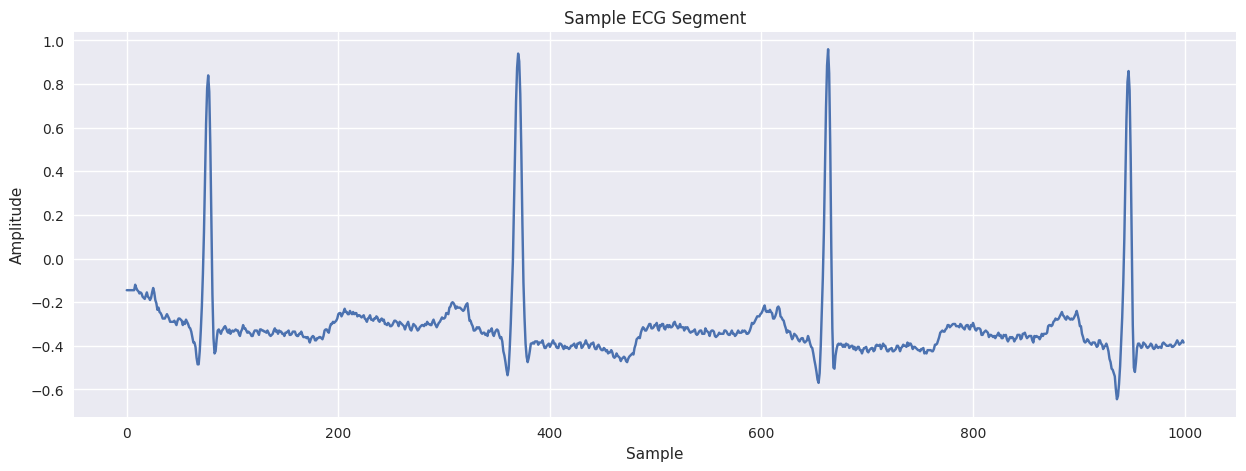

In [4]:
# Load ECG data
record_path = 'data/mit-bih-arrhythmia-database-1.0.0/100'  # Example record 
record = wfdb.rdrecord(record_path)
signals = record.p_signal

# Read annotations
ann = wfdb.rdann(record_path, 'atr')
annotations = ann.symbol

# Print data information
print(f"Signal shape: {signals.shape}")
print(f"Number of annotations: {len(annotations)}")
print(f"Unique beat types: {np.unique(annotations)}")

# Plot sample ECG segment
plt.figure(figsize=(15, 5))
plt.plot(signals[:1000, 0])
plt.title('Sample ECG Segment')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Data shape: (2273, 180, 2)
Label distribution: [2239   34]


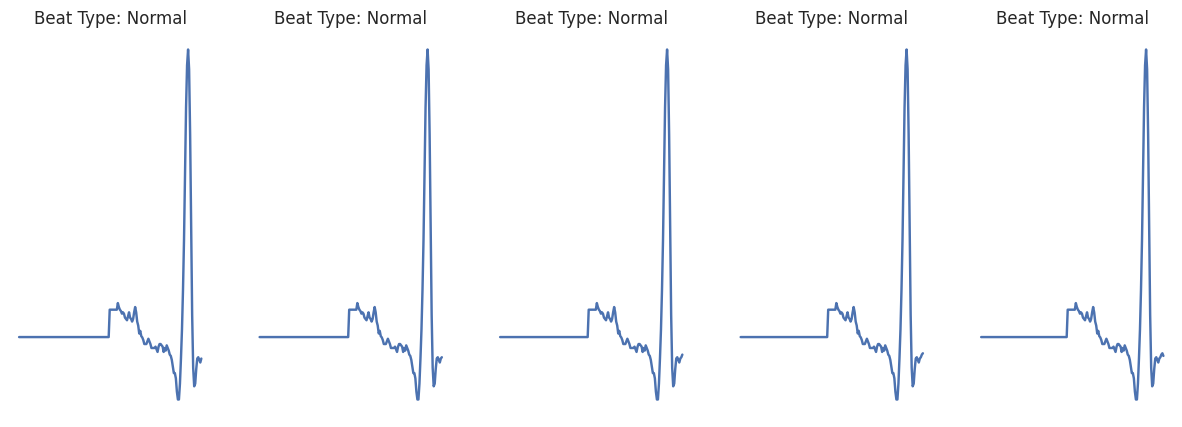

In [5]:
# Preprocess ECG data
window_size = 180

# Normalize signals
signals = (signals - np.mean(signals)) / np.std(signals)

# Extract beats
X = []
y = []

for i, ann in enumerate(annotations):
    if ann in ['N', 'L', 'R', 'A', 'V']:  # Normal and abnormal beats
        # Get window around beat
        start = max(0, i - window_size//2)
        end = min(len(signals), i + window_size//2)
        
        # Pad if necessary
        if start == 0:
            pad_left = window_size//2 - i
            segment = np.pad(signals[start:end], ((pad_left, 0), (0, 0)))
        elif end == len(signals):
            pad_right = window_size//2 - (len(signals) - i)
            segment = np.pad(signals[start:end], ((0, pad_right), (0, 0)))
        else:
            segment = signals[start:end]
        
        X.append(segment)
        
        # Convert annotation to label
        if ann == 'N':
            y.append(0)  # Normal
        else:
            y.append(1)  # Abnormal

X = np.array(X)
y = np.array(y)

print(f"Data shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")

# Plot sample beats
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(X[i, :, 0])
    plt.title(f'Beat Type: {"Normal" if y[i] == 0 else "Abnormal"}')
    plt.axis('off')
plt.show()

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 2. Model Implementation

In [96]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Create simple neural network
def create_simple_nn(input_shape):
    """
    Create a simple neural network for ECG classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use binary crossentropy loss
    - Must include AUC metric
    
    Goals:
    - Achieve > 75% accuracy on test set
    - Achieve AUC > 0.80
    - Achieve F1-score > 0.70
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (180, 2) for ECG windows)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
        ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

# Create and compile model
model = create_simple_nn(input_shape=(180, 2))
model.summary()



Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_20 (Flatten)            │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 256)            │        92,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,193 (532.00 KB)

 Trainable params: 136,193 (532.00 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Training and Evaluation

Epoch 1/30


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9246 - auc_21: 0.4941 - loss: 0.2713 - val_accuracy: 0.9945 - val_auc_21: 0.3771 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9857 - auc_21: 0.5387 - loss: 0.1120 - val_accuracy: 0.9945 - val_auc_21: 0.3039 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9854 - auc_21: 0.5772 - loss: 0.0923 - val_accuracy: 0.9945 - val_auc_21: 0.3039 - val_loss: 0.0427 - learning_rate: 0.0010
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9854 - auc_21: 0.6555 - loss: 0.0827 - val_accuracy: 0.9945 - val_auc_21: 0.3674 - val_loss: 0.0460 - learning_rate: 0.0010
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9848 - auc_21: 0.5181 - loss: 0.1022 - val_accuracy: 0.9945 - val_auc_21: 0.3218 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9857 -

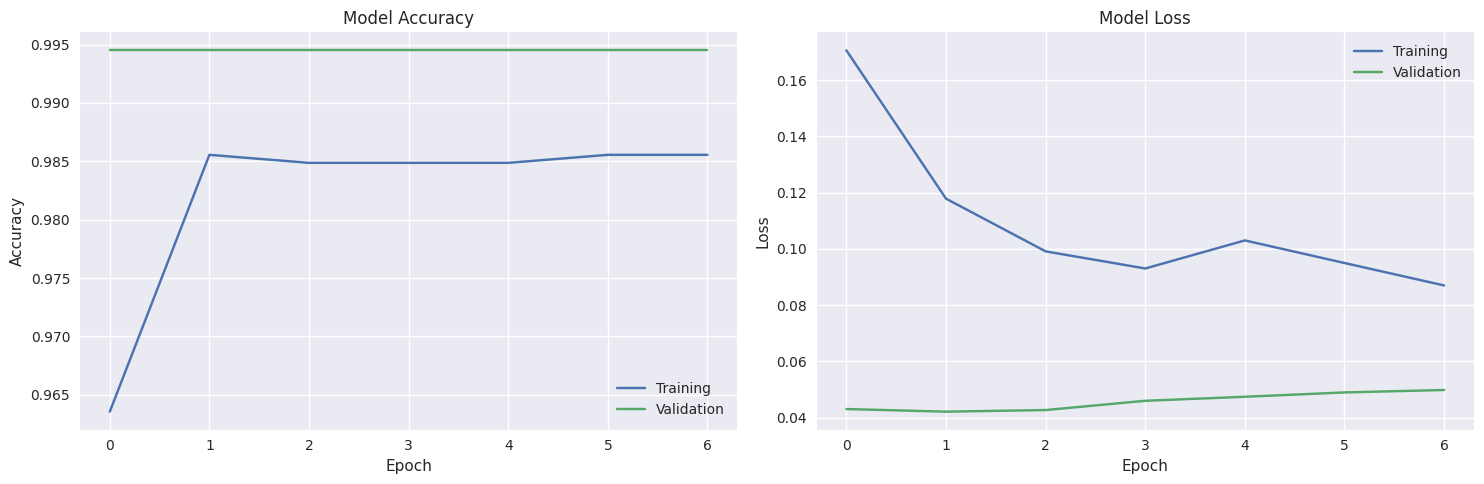

In [97]:

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/ecg_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks)


# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9688 - auc_21: 0.3065 - loss: 0.1731

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9722 - auc_21: 0.4936 - loss: 0.1668 
Test accuracy: 0.9758
Test AUC: 0.5977
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


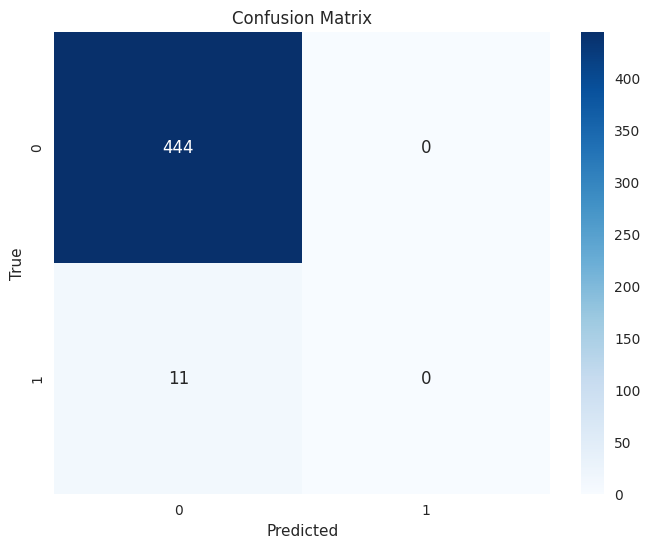

/tmp/ipykernel_49779/3918600470.py:23: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [98]:
# Evaluate model
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Get predictions
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.numpy().ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

# Save metrics
metrics = {
    'model': 'ecg_classifier',
    'accuracy': float(test_accuracy),
    'auc': float(test_auc),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_3/ecg_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"auc: {metrics['auc']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")